In [1]:
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import pickle
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import pandas as pd
import seaborn as sns
from matplotlib import colors, pyplot as plt
%matplotlib inline

## GPU

In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

DEVICE = torch.device("cuda")

CUDA is available!  Training on GPU ...


## загрузка данных

In [3]:
! pip install kaggle

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

#скачиваем датасет с kaggle и распаковываем архив
! kaggle competitions download journey-springfield
!unzip journey-springfield.zip
print('Done!')

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/simpsons_dataset/moe_szyslak/pic_1026.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1027.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1028.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1029.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1030.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1031.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1032.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1033.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1034.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1035.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1036.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1037.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1038.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1039.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pi

In [4]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]

In [5]:
#делим изображения на обучение и валидацию
from sklearn.model_selection import train_test_split

train_files, val_files = train_test_split(train_val_files,
                                          test_size=0.25,
                                          stratify=train_val_labels)

## гиперпараметры

In [6]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']

# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224

#нормализация и аугментации
transform_val = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])

transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.RandomCrop (224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ])

#размер батча для даталоадера
batch_size = 100

#функция потерь
criterion = nn.CrossEntropyLoss()

## перевод картинок в тензоры

In [7]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [8]:
#Датасет для обучения
transform = transform_train

train_dataset = SimpsonsDataset(train_files, mode='train')

In [9]:
#Датасет для валидации
transform = transform_val

val_dataset = SimpsonsDataset(val_files, mode='val')

## DataLoaders

In [10]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## trainloop

In [21]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        #inputs = inputs.to(DEVICE)
        #labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [22]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [23]:
def train(train_files, val_files, model, epochs, batch_size):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    best_model_wts = model.state_dict()
    best_acc = 0.0

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            if val_acc > best_acc:
              best_acc = val_acc
              best_model_wts = model.state_dict()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)

    print('Best val Acc: {:4f}'.format(best_acc))

    return history, best_acc, best_model_wts

## загрузка модели

In [47]:
from torchvision.models import resnet50, ResNet50_Weights

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

n_classes = len(np.unique(train_val_labels)) #количество классов для нашей задачи
num_features = 2048 # num_features -- это размерность вектора фич, поступающего на вход FC-слою
model.fc = nn.Linear(num_features, n_classes)

#выбираем оптимизатор и learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#снижение learning rate через каждые step_size эпох в gamma раз
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = model.to(DEVICE)

history, best_acc, best_model_wts = train(train_dataset, val_dataset, model=model, epochs=15, batch_size=50)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 0.8117136788727775


epoch:   7%|▋         | 1/15 [04:59<1:09:49, 299.26s/it]


Epoch 001 train_loss: 0.8117     val_loss 0.1881 train_acc 0.8267 val_acc 0.9562
loss 0.2791058502413147


epoch:  13%|█▎        | 2/15 [09:56<1:04:32, 297.85s/it]


Epoch 002 train_loss: 0.2791     val_loss 0.1348 train_acc 0.9277 val_acc 0.9652
loss 0.14137319669566933


epoch:  20%|██        | 3/15 [14:53<59:31, 297.61s/it]


Epoch 003 train_loss: 0.1414     val_loss 0.0956 train_acc 0.9631 val_acc 0.9776
loss 0.10799983439665553


epoch:  27%|██▋       | 4/15 [19:38<53:39, 292.69s/it]


Epoch 004 train_loss: 0.1080     val_loss 0.0882 train_acc 0.9723 val_acc 0.9784
loss 0.08219833408495246


epoch:  33%|███▎      | 5/15 [24:06<47:17, 283.75s/it]


Epoch 005 train_loss: 0.0822     val_loss 0.0769 train_acc 0.9774 val_acc 0.9838
loss 0.05287895502024981


epoch:  40%|████      | 6/15 [28:32<41:40, 277.86s/it]


Epoch 006 train_loss: 0.0529     val_loss 0.0819 train_acc 0.9862 val_acc 0.9799
loss 0.03941462727232232


epoch:  47%|████▋     | 7/15 [32:57<36:29, 273.65s/it]


Epoch 007 train_loss: 0.0394     val_loss 0.0664 train_acc 0.9892 val_acc 0.9853
loss 0.057306542066430446


epoch:  53%|█████▎    | 8/15 [37:24<31:39, 271.36s/it]


Epoch 008 train_loss: 0.0573     val_loss 0.0879 train_acc 0.9848 val_acc 0.9778
loss 0.054048786778590284


epoch:  60%|██████    | 9/15 [41:50<26:59, 269.85s/it]


Epoch 009 train_loss: 0.0540     val_loss 0.0608 train_acc 0.9854 val_acc 0.9868
loss 0.04583168305087111


epoch:  67%|██████▋   | 10/15 [46:17<22:23, 268.73s/it]


Epoch 010 train_loss: 0.0458     val_loss 0.0966 train_acc 0.9873 val_acc 0.9805
loss 0.038135366923984865


epoch:  73%|███████▎  | 11/15 [50:43<17:51, 267.98s/it]


Epoch 011 train_loss: 0.0381     val_loss 0.0553 train_acc 0.9891 val_acc 0.9903
loss 0.028355168443250083


epoch:  80%|████████  | 12/15 [55:09<13:21, 267.33s/it]


Epoch 012 train_loss: 0.0284     val_loss 0.0673 train_acc 0.9923 val_acc 0.9859
loss 0.029246292709439913


epoch:  87%|████████▋ | 13/15 [59:36<08:54, 267.37s/it]


Epoch 013 train_loss: 0.0292     val_loss 0.0791 train_acc 0.9922 val_acc 0.9847
loss 0.015014114674762177


epoch:  93%|█████████▎| 14/15 [1:04:05<04:27, 267.72s/it]


Epoch 014 train_loss: 0.0150     val_loss 0.0586 train_acc 0.9957 val_acc 0.9883
loss 0.028557295171066015


epoch: 100%|██████████| 15/15 [1:08:32<00:00, 274.17s/it]


Epoch 015 train_loss: 0.0286     val_loss 0.0691 train_acc 0.9921 val_acc 0.9834


## график обучения

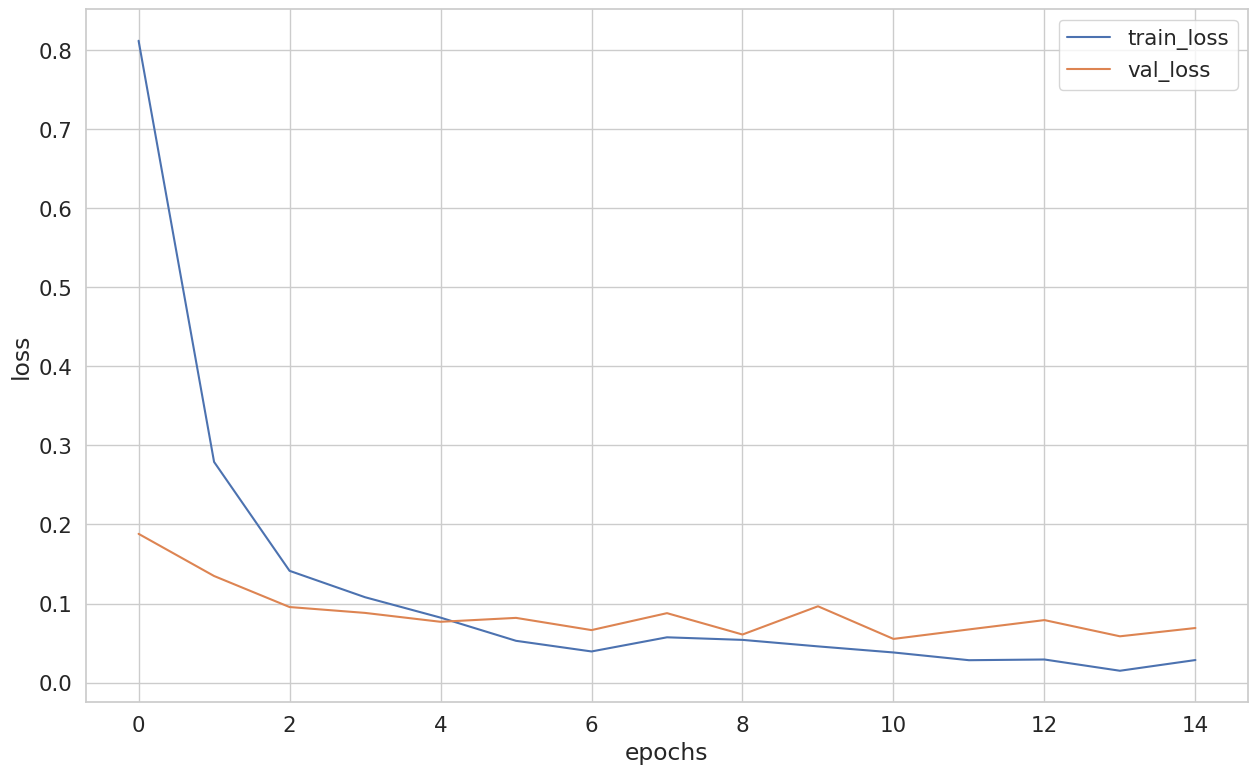

In [51]:
loss, acc, val_loss, val_acc = zip(*history)

sns.set(style='whitegrid', font_scale = 1.4)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## предсказание

In [52]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [72]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds_class = [label_encoder.classes_[i] for i in y_pred]

from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='weighted')

1.0

In [73]:
test_dataset = SimpsonsDataset(test_files, mode='test')
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [77]:
my_submit = pd.read_csv("sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [81]:
my_submit.to_csv('simpsons_fintuning.csv', index=False)

## частичная разморозка

In [56]:
model_2 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

In [59]:
model_2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [76]:
layers_to_unfreeze = 5

# Выключаем подсчет градиентов для слоев, которые не будем обучать
for param in model_2.layer4[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

# Заменяем Fully-Connected слой на наш линейный классификатор
model_2.classifier = nn.Linear(num_features, n_classes)

#в обучении исправляем оптимизатор (чтобы считался только в размороженных слоях)
optimizer = torch.optim.Adam(list(model_2.layer4.parameters())[-layers_to_unfreeze:] +
                      list(model_2.classifier.parameters()), lr=1e-4)

# Использовать ли GPU
if train_on_gpu:
    model_2 = model_2.cuda()

In [64]:
history_2, best_acc_2, best_model_wts_2 = train_ft(train_dataset, val_dataset, model=model_2, epochs=15, batch_size=50)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 6.703921926257732


epoch:   7%|▋         | 1/15 [04:49<1:07:30, 289.33s/it]


Epoch 001 train_loss: 6.7039     val_loss 4.4693 train_acc 0.1063 val_acc 0.3489
loss 1.7928389056229015


epoch:  13%|█▎        | 2/15 [09:21<1:00:30, 279.30s/it]


Epoch 002 train_loss: 1.7928     val_loss 1.3928 train_acc 0.5954 val_acc 0.6595
loss 1.270637566127992


epoch:  20%|██        | 3/15 [13:52<55:08, 275.68s/it]


Epoch 003 train_loss: 1.2706     val_loss 1.1766 train_acc 0.6810 val_acc 0.7041
loss 1.086786381210732


epoch:  27%|██▋       | 4/15 [18:25<50:18, 274.43s/it]


Epoch 004 train_loss: 1.0868     val_loss 1.0242 train_acc 0.7223 val_acc 0.7348
loss 0.9670771495978068


epoch:  33%|███▎      | 5/15 [22:57<45:36, 273.63s/it]


Epoch 005 train_loss: 0.9671     val_loss 0.9206 train_acc 0.7470 val_acc 0.7612
loss 0.879171661912533


epoch:  40%|████      | 6/15 [27:29<40:56, 273.00s/it]


Epoch 006 train_loss: 0.8792     val_loss 0.8642 train_acc 0.7725 val_acc 0.7673
loss 0.8082900073499587


epoch:  47%|████▋     | 7/15 [32:03<36:25, 273.22s/it]


Epoch 007 train_loss: 0.8083     val_loss 0.8050 train_acc 0.7867 val_acc 0.7820
loss 0.7494316032087889


epoch:  53%|█████▎    | 8/15 [36:37<31:53, 273.42s/it]


Epoch 008 train_loss: 0.7494     val_loss 0.7444 train_acc 0.8022 val_acc 0.8017
loss 0.7043012193535777


epoch:  60%|██████    | 9/15 [41:09<27:18, 273.03s/it]


Epoch 009 train_loss: 0.7043     val_loss 0.7302 train_acc 0.8141 val_acc 0.8024
loss 0.6631853295948955


epoch:  67%|██████▋   | 10/15 [45:40<22:41, 272.37s/it]


Epoch 010 train_loss: 0.6632     val_loss 0.6871 train_acc 0.8231 val_acc 0.8126
loss 0.6226804832476963


epoch:  73%|███████▎  | 11/15 [50:12<18:09, 272.27s/it]


Epoch 011 train_loss: 0.6227     val_loss 0.6716 train_acc 0.8340 val_acc 0.8198
loss 0.59307521572158


epoch:  80%|████████  | 12/15 [55:07<13:57, 279.33s/it]


Epoch 012 train_loss: 0.5931     val_loss 0.6288 train_acc 0.8421 val_acc 0.8246
loss 0.5627429223898164


epoch:  87%|████████▋ | 13/15 [1:00:13<09:35, 287.53s/it]


Epoch 013 train_loss: 0.5627     val_loss 0.5923 train_acc 0.8483 val_acc 0.8355
loss 0.5384376615283976


epoch:  93%|█████████▎| 14/15 [1:04:48<04:43, 283.68s/it]


Epoch 014 train_loss: 0.5384     val_loss 0.5765 train_acc 0.8564 val_acc 0.8485
loss 0.5083875881956599


epoch: 100%|██████████| 15/15 [1:09:23<00:00, 277.54s/it]


Epoch 015 train_loss: 0.5084     val_loss 0.5585 train_acc 0.8663 val_acc 0.8491
Best val Acc: 0.849064


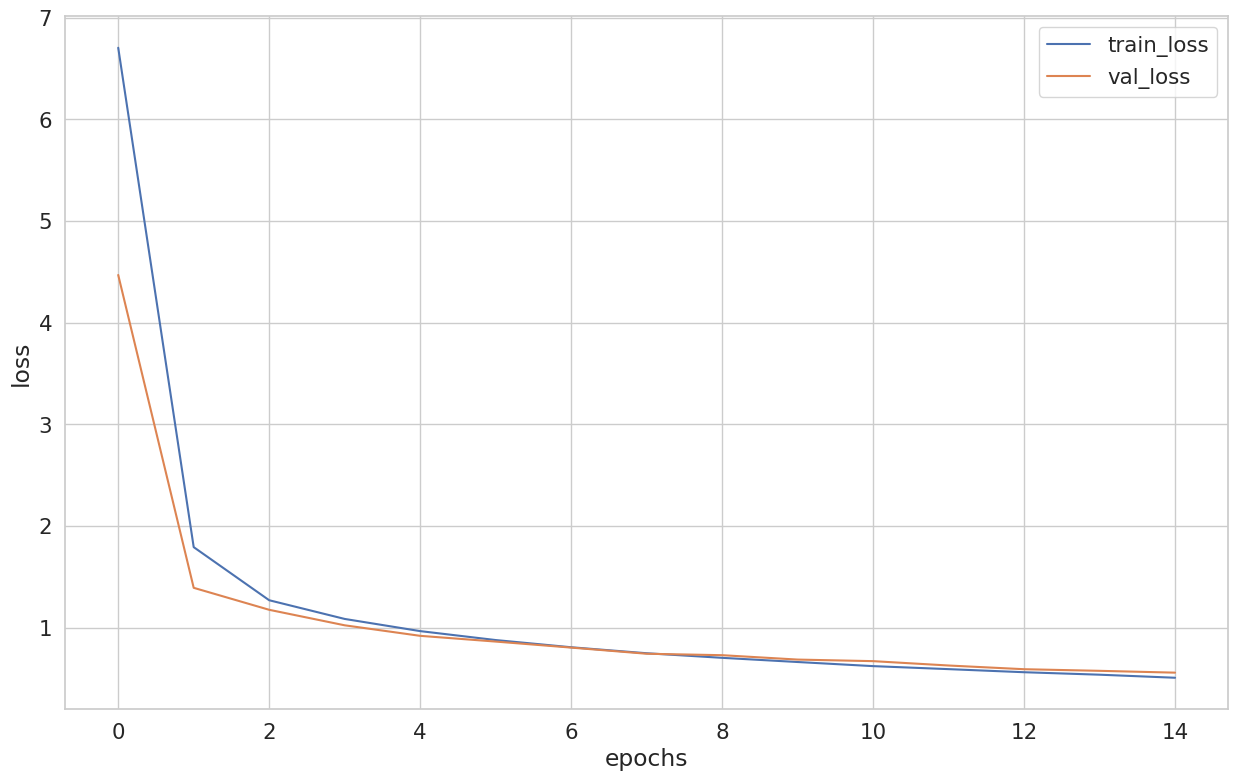

In [66]:
loss_2, acc_2, val_loss_2, val_acc_2 = zip(*history_2)

sns.set(style='whitegrid', font_scale = 1.4)
plt.figure(figsize=(15, 9))
plt.plot(loss_2, label="train_loss")
plt.plot(val_loss_2, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [68]:
probs_ims_2 = predict(model_2, imgs)

y_pred_2 = np.argmax(probs_ims_2,-1)

preds_class_2 = [label_encoder.classes_[i] for i in y_pred_2]

f1_score(actual_labels, y_pred_2, average='weighted')

1.0

In [69]:
probs_2 = predict(model_2, test_loader)

preds_2 = label_encoder.inverse_transform(np.argmax(probs_2, axis=1))

my_submit_2 = pd.read_csv("sample_submission.csv")
my_submit_2 = pd.DataFrame({'Id': test_filenames, 'Expected': preds_2})

my_submit.to_csv('simpsons_fintuning.csv', index=False)

## разный learning rate для разных слоев

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

n_classes = len(np.unique(train_val_labels)) #количество классов для нашей задачи
num_features = 2048 # num_features -- это размерность вектора фич, поступающего на вход FC-слою

In [ ]:
model_diff_lr = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

model_diff_lr.classifier = nn.Linear(num_features, n_classes)

#в обучении меняем оптимизатор: для каждого слоя сети будет считаться свой learning rate
#чем дальше от выходного слоя, тем меньше lr
optimizer = torch.optim.Adam(params=[
        {"params": model_diff_lr.classifier.parameters()},
        {"params": model_diff_lr.layer4.parameters(), "lr": 1e-5},
        {"params": model_diff_lr.layer3.parameters(), "lr": 1e-6},
        {"params": model_diff_lr.layer2.parameters(), "lr": 1e-7,},
        {"params": model_diff_lr.layer1.parameters(), "lr": 1e-8,}
        ], lr=1e-4)

model_diff_lr = model_diff_lr.to(DEVICE)

history_diff_lr, best_acc_diff_lr, best_model_wts_diff_lr = train(train_dataset, val_dataset, model=model_diff_lr, epochs=15, batch_size=50)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 6.318475256589456


epoch:   7%|▋         | 1/15 [05:09<1:12:12, 309.48s/it]


Epoch 001 train_loss: 6.3185     val_loss 3.1252 train_acc 0.1696 val_acc 0.5558
loss 1.111043557694584


epoch:  13%|█▎        | 2/15 [10:21<1:07:19, 310.73s/it]


Epoch 002 train_loss: 1.1110     val_loss 0.7895 train_acc 0.7775 val_acc 0.8229


In [ ]:
loss_diff_lr, acc_diff_lr, val_loss_diff_lr, val_acc_diff_lr = zip(*history_diff_lr)

sns.set(style='whitegrid', font_scale = 1.4)
plt.figure(figsize=(15, 9))
plt.plot(loss_diff_lr, label="train_loss")
plt.plot(val_loss_diff_lr, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

##сохранить\загрузить веса

In [48]:
#сохраняем лучшие веса
torch.save(model.state_dict(), 'BestWeights.pth')

#подгружаем лучшие веса
model.load_state_dict(torch.load('BestWeights.pth'))

